
### Data Preparation
### Session Level Data

In [87]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

# 1. Data Wrangling
## 1.1 Importing the datasets

In [88]:
clicks = pd.read_csv("yoochoose-clicks.dat", names=['Session ID', 'Timestamp', 'Item ID', 'Category'],parse_dates = ['Timestamp'],low_memory=False)
buys = pd.read_csv("yoochoose-buys.dat", names=['Session ID', 'Timestamp', 'Item ID', 'Price', 'Quantity'],parse_dates = ['Timestamp'])

In [89]:
clicks.head()

,Session ID,Timestamp,Item ID,Category
0,1,2014-04-07 10:51:09.277000+00:00,214536502,0
1,1,2014-04-07 10:54:09.868000+00:00,214536500,0
2,1,2014-04-07 10:54:46.998000+00:00,214536506,0
3,1,2014-04-07 10:57:00.306000+00:00,214577561,0
4,2,2014-04-07 13:56:37.614000+00:00,214662742,0


In [90]:
buys.head()

,Session ID,Timestamp,Item ID,Price,Quantity
0,420374,2014-04-06 18:44:58.314000+00:00,214537888,12462,1
1,420374,2014-04-06 18:44:58.325000+00:00,214537850,10471,1
2,281626,2014-04-06 09:40:13.032000+00:00,214535653,1883,1
3,420368,2014-04-04 06:13:28.848000+00:00,214530572,6073,1
4,420368,2014-04-04 06:13:28.858000+00:00,214835025,2617,1


## 1.2 EDA 

Both Clicks and Buys datasets contain 6 months of data going from April to September 2014.

In [91]:
# timespan of the clicks dataset
print("Clicks min date:",clicks["Timestamp"].dt.date.min())
print("Clicks max date:",clicks["Timestamp"].dt.date.max())

# timespan of the buys dataset
print("Buys min date:",buys["Timestamp"].dt.date.min())
print("Buys max date:",buys["Timestamp"].dt.date.max())

Clicks min date: 2014-04-01
Clicks max date: 2014-09-30
Buys min date: 2014-04-01
Buys max date: 2014-09-30


In [92]:
# shape of the datasets
print('Clicks shape:',clicks.shape)
print('Buys shape:',buys.shape)

Clicks shape: (33003944, 4)
Buys shape: (1150753, 5)


### 1.2.1 Proportion of sessions resulting in purchase

In [93]:
# number of unique sessions
print(f"Number of unique sessions clicks dataset: {clicks['Session ID'].nunique()}") 
print(f"Number of unique sessions buys dataset: {buys['Session ID'].nunique()}") 
# proportion of sessions resulting in purchase
print(f"The proportion of session resulting in a purchase is: {round(buys['Session ID'].nunique()/clicks['Session ID'].nunique(),3)}") 

Number of unique sessions clicks dataset: 9249729
Number of unique sessions buys dataset: 509696
The proportion of session resulting in a purchase is: 0.055


The training data is imbalanced and we will have to take this into account when training the model.

In [94]:
# check rows with price = 0
print('Num. entries with price = 0 is:',buys[buys['Price']==0].shape[0])
# check rows with quantity = 0
print('Num. entries with quantity = 0 is:',buys[buys['Quantity']==0].shape[0])

Num. entries with price = 0 is: 610030
Num. entries with quantity = 0 is: 610030


We notice that there are 610030 entries with price and quantity equal to zero. These rows also appear in sessions in which users actually purchased other items such as session 420287. 

We believe this is due to the anonymisation of the dataset because it seems quite unlikely that it is a mistake given that these rows make up more than half of the dataset. Therefore, we use them to train our model.

### 1.2.2 Add Buy Flag 
If the session ended in a buy activity

In [95]:
# add column of 1 to the buys dataset to identify sessions with purchase after merging with clicks dataset
clicks['buy_flag'] = clicks['Session ID'].isin(buys['Session ID'])
clicks.head()

,Session ID,Timestamp,Item ID,Category,buy_flag
0,1,2014-04-07 10:51:09.277000+00:00,214536502,0,False
1,1,2014-04-07 10:54:09.868000+00:00,214536500,0,False
2,1,2014-04-07 10:54:46.998000+00:00,214536506,0,False
3,1,2014-04-07 10:57:00.306000+00:00,214577561,0,False
4,2,2014-04-07 13:56:37.614000+00:00,214662742,0,False


### 1.2.3 Extract time hour, day of the week, number of the month 

In [96]:
# time
clicks['time'] =clicks.Timestamp.dt.time
# hour
clicks['hour'] =clicks.Timestamp.dt.hour
# day
clicks['day'] =clicks.Timestamp.dt.dayofweek
# month
clicks['month'] =clicks.Timestamp.dt.month

clicks.head()

,Session ID,Timestamp,Item ID,Category,buy_flag,time,hour,day,month
0,1,2014-04-07 10:51:09.277000+00:00,214536502,0,False,10:51:09.277000,10,0,4
1,1,2014-04-07 10:54:09.868000+00:00,214536500,0,False,10:54:09.868000,10,0,4
2,1,2014-04-07 10:54:46.998000+00:00,214536506,0,False,10:54:46.998000,10,0,4
3,1,2014-04-07 10:57:00.306000+00:00,214577561,0,False,10:57:00.306000,10,0,4
4,2,2014-04-07 13:56:37.614000+00:00,214662742,0,False,13:56:37.614000,13,0,4


### 1.2.4 Length of each session

In [97]:
# length of each session - time between 1st and last clicks

# get first and last click time
time_first_click = clicks.groupby('Session ID')['Timestamp'].min().reset_index(name='First')
time_last_click = clicks.groupby('Session ID')['Timestamp'].max().reset_index(name='Last')

session_length = pd.merge(time_first_click,time_last_click, on = 'Session ID')
session_length['session_length'] = (session_length['Last']-session_length['First']).astype('timedelta64[s]')
session_length.head()

,Session ID,First,Last,session_length
0,1,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0
1,2,2014-04-07 13:56:37.614000+00:00,2014-04-07 14:02:36.889000+00:00,359.0
2,3,2014-04-02 13:17:46.940000+00:00,2014-04-02 13:30:12.318000+00:00,745.0
3,4,2014-04-07 12:09:10.948000+00:00,2014-04-07 12:26:25.416000+00:00,1034.0
4,6,2014-04-06 16:58:20.848000+00:00,2014-04-06 17:02:26.976000+00:00,246.0


In [98]:
print('length mean:', session_length['session_length'].mean())
print('length median:', session_length['session_length'].median())

length mean: 381.2030260562228
length median: 127.0


### Is the average length of a session different between buy and non-buy sessions?

In [99]:
# add column of 1 to session_length to identify sessions with purchase 
session_length['buy_flag'] = session_length['Session ID'].isin(buys['Session ID'])
session_length.head()

,Session ID,First,Last,session_length,buy_flag
0,1,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0,False
1,2,2014-04-07 13:56:37.614000+00:00,2014-04-07 14:02:36.889000+00:00,359.0,False
2,3,2014-04-02 13:17:46.940000+00:00,2014-04-02 13:30:12.318000+00:00,745.0,False
3,4,2014-04-07 12:09:10.948000+00:00,2014-04-07 12:26:25.416000+00:00,1034.0,False
4,6,2014-04-06 16:58:20.848000+00:00,2014-04-06 17:02:26.976000+00:00,246.0,False


In [100]:
avg_length_difference=session_length[['buy_flag','session_length']].groupby('buy_flag').mean()
session_length.drop(columns=['buy_flag'], inplace=True)
avg_length_difference.head()

,session_length
buy_flag,
False,352.894155
True,866.630544


The average length of sessions which end with a purchase (866 sec or 14 min) is more than twice that of those sessions without any purchase (352 sec or almost 6 min).

### 1.2.5 Dwell time (on items' clicks)

In [101]:
# Compute dwell time for each click 
clicks['lag'] = clicks.groupby(['Session ID'])['Timestamp'].shift(-1)
clicks['dwell_time'] = clicks["lag"] - clicks["Timestamp"] 
clicks['dwell_time'] = clicks['dwell_time'].dt.seconds

clicks.head()

,Session ID,Timestamp,Item ID,Category,buy_flag,time,hour,day,month,lag,dwell_time
0,1,2014-04-07 10:51:09.277000+00:00,214536502,0,False,10:51:09.277000,10,0,4,2014-04-07 10:54:09.868000+00:00,180.0
1,1,2014-04-07 10:54:09.868000+00:00,214536500,0,False,10:54:09.868000,10,0,4,2014-04-07 10:54:46.998000+00:00,37.0
2,1,2014-04-07 10:54:46.998000+00:00,214536506,0,False,10:54:46.998000,10,0,4,2014-04-07 10:57:00.306000+00:00,133.0
3,1,2014-04-07 10:57:00.306000+00:00,214577561,0,False,10:57:00.306000,10,0,4,NaT,NaN
4,2,2014-04-07 13:56:37.614000+00:00,214662742,0,False,13:56:37.614000,13,0,4,2014-04-07 13:57:19.373000+00:00,41.0


### 1.2.6 Average and maximun dwell time per session

In [102]:
# Merge the session length with clicks data
clicks = clicks.merge(session_length, on='Session ID', how='left')
clicks.head()

,Session ID,Timestamp,Item ID,Category,buy_flag,time,hour,day,month,lag,dwell_time,First,Last,session_length
0,1,2014-04-07 10:51:09.277000+00:00,214536502,0,False,10:51:09.277000,10,0,4,2014-04-07 10:54:09.868000+00:00,180.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0
1,1,2014-04-07 10:54:09.868000+00:00,214536500,0,False,10:54:09.868000,10,0,4,2014-04-07 10:54:46.998000+00:00,37.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0
2,1,2014-04-07 10:54:46.998000+00:00,214536506,0,False,10:54:46.998000,10,0,4,2014-04-07 10:57:00.306000+00:00,133.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0
3,1,2014-04-07 10:57:00.306000+00:00,214577561,0,False,10:57:00.306000,10,0,4,NaT,NaN,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0
4,2,2014-04-07 13:56:37.614000+00:00,214662742,0,False,13:56:37.614000,13,0,4,2014-04-07 13:57:19.373000+00:00,41.0,2014-04-07 13:56:37.614000+00:00,2014-04-07 14:02:36.889000+00:00,359.0


Get max and average time between two clicks

In [103]:
#create a copy of clicks data and calculate the max and average session time between two clicks
#remove the time where its NaN basically for last click of session
clicks_new=clicks.copy()
clicks_new = clicks_new.dropna()
clicks_new.head()

,Session ID,Timestamp,Item ID,Category,buy_flag,time,hour,day,month,lag,dwell_time,First,Last,session_length
0,1,2014-04-07 10:51:09.277000+00:00,214536502,0,False,10:51:09.277000,10,0,4,2014-04-07 10:54:09.868000+00:00,180.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0
1,1,2014-04-07 10:54:09.868000+00:00,214536500,0,False,10:54:09.868000,10,0,4,2014-04-07 10:54:46.998000+00:00,37.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0
2,1,2014-04-07 10:54:46.998000+00:00,214536506,0,False,10:54:46.998000,10,0,4,2014-04-07 10:57:00.306000+00:00,133.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0
4,2,2014-04-07 13:56:37.614000+00:00,214662742,0,False,13:56:37.614000,13,0,4,2014-04-07 13:57:19.373000+00:00,41.0,2014-04-07 13:56:37.614000+00:00,2014-04-07 14:02:36.889000+00:00,359.0
5,2,2014-04-07 13:57:19.373000+00:00,214662742,0,False,13:57:19.373000,13,0,4,2014-04-07 13:58:37.446000+00:00,78.0,2014-04-07 13:56:37.614000+00:00,2014-04-07 14:02:36.889000+00:00,359.0


In [104]:
clicks_new.shape

(23754215, 14)

In [105]:
clicks_new1 = clicks_new.groupby(['Session ID'], as_index=False).agg({'dwell_time': ['mean', 'max']})
clicks_new1.head()

Session ID   dwell_time        
                     mean     max
0          1   116.666667   180.0
1          2    71.400000   118.0
2          3   372.000000   495.0
3          4  1034.000000  1034.0
4          6   246.000000   246.0

In [106]:
clicks = clicks.merge(clicks_new1, on='Session ID',how='left')
clicks.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,Session ID,Timestamp,Item ID,Category,buy_flag,time,hour,day,month,lag,dwell_time,First,Last,session_length,"(dwell_time, mean)","(dwell_time, max)"
0,1,2014-04-07 10:51:09.277000+00:00,214536502,0,False,10:51:09.277000,10,0,4,2014-04-07 10:54:09.868000+00:00,180.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0,116.666667,180.0
1,1,2014-04-07 10:54:09.868000+00:00,214536500,0,False,10:54:09.868000,10,0,4,2014-04-07 10:54:46.998000+00:00,37.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0,116.666667,180.0
2,1,2014-04-07 10:54:46.998000+00:00,214536506,0,False,10:54:46.998000,10,0,4,2014-04-07 10:57:00.306000+00:00,133.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0,116.666667,180.0
3,1,2014-04-07 10:57:00.306000+00:00,214577561,0,False,10:57:00.306000,10,0,4,NaT,NaN,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0,116.666667,180.0
4,2,2014-04-07 13:56:37.614000+00:00,214662742,0,False,13:56:37.614000,13,0,4,2014-04-07 13:57:19.373000+00:00,41.0,2014-04-07 13:56:37.614000+00:00,2014-04-07 14:02:36.889000+00:00,359.0,71.400000,118.0


In [107]:
# Rename some of the columns for consistency
clicks=clicks.rename(columns={('dwell_time', 'mean'):'avg_dwell_time',('dwell_time', 'max'):'max_dwell_time'})
clicks.head()

,Session ID,Timestamp,Item ID,Category,buy_flag,time,hour,day,month,lag,dwell_time,First,Last,session_length,avg_dwell_time,max_dwell_time
0,1,2014-04-07 10:51:09.277000+00:00,214536502,0,False,10:51:09.277000,10,0,4,2014-04-07 10:54:09.868000+00:00,180.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0,116.666667,180.0
1,1,2014-04-07 10:54:09.868000+00:00,214536500,0,False,10:54:09.868000,10,0,4,2014-04-07 10:54:46.998000+00:00,37.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0,116.666667,180.0
2,1,2014-04-07 10:54:46.998000+00:00,214536506,0,False,10:54:46.998000,10,0,4,2014-04-07 10:57:00.306000+00:00,133.0,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0,116.666667,180.0
3,1,2014-04-07 10:57:00.306000+00:00,214577561,0,False,10:57:00.306000,10,0,4,NaT,NaN,2014-04-07 10:51:09.277000+00:00,2014-04-07 10:57:00.306000+00:00,351.0,116.666667,180.0
4,2,2014-04-07 13:56:37.614000+00:00,214662742,0,False,13:56:37.614000,13,0,4,2014-04-07 13:57:19.373000+00:00,41.0,2014-04-07 13:56:37.614000+00:00,2014-04-07 14:02:36.889000+00:00,359.0,71.400000,118.0


Keep only the required fields in the dataset

In [108]:
clicks_mid = clicks[['Session ID','Item ID','Category','hour','day','month','buy_flag','session_length','dwell_time','avg_dwell_time','max_dwell_time']]
clicks_mid.head()

,Session ID,Item ID,Category,hour,day,month,buy_flag,session_length,dwell_time,avg_dwell_time,max_dwell_time
0,1,214536502,0,10,0,4,False,351.0,180.0,116.666667,180.0
1,1,214536500,0,10,0,4,False,351.0,37.0,116.666667,180.0
2,1,214536506,0,10,0,4,False,351.0,133.0,116.666667,180.0
3,1,214577561,0,10,0,4,False,351.0,NaN,116.666667,180.0
4,2,214662742,0,13,0,4,False,359.0,41.0,71.400000,118.0


### Do higher average and max dwell times correspond to a higher purchase ratio?

In [110]:
clicks_mid2=clicks_mid[["Session ID","buy_flag","avg_dwell_time","max_dwell_time"]].groupby('Session ID').max()
clicks_mid2.groupby("buy_flag").mean()

,avg_dwell_time,max_dwell_time
buy_flag,,
False,166.303142,275.882293
True,211.865831,479.762953


Both average and max dwell times are significantly higher for sessions that end with a purchase. 

### 1.2.7 Number of clicks per session

In [114]:
# number of clicks per session
clicks_mid['num_clicks_session']= clicks_mid[["Session ID","Item ID"]].groupby("Session ID").transform('count')
clicks_mid.head()

<ipython-input-114-b0d416a6b3b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks_mid['num_clicks_session']= clicks_mid[["Session ID","Item ID"]].groupby("Session ID").transform('count')


,Session ID,Item ID,Category,hour,day,month,buy_flag,session_length,dwell_time,avg_dwell_time,max_dwell_time,num_clicks_session
0,1,214536502,0,10,0,4,False,351.0,180.0,116.666667,180.0,4
1,1,214536500,0,10,0,4,False,351.0,37.0,116.666667,180.0,4
2,1,214536506,0,10,0,4,False,351.0,133.0,116.666667,180.0,4
3,1,214577561,0,10,0,4,False,351.0,NaN,116.666667,180.0,4
4,2,214662742,0,13,0,4,False,359.0,41.0,71.400000,118.0,6


In [115]:
plt.style.use('seaborn')

Text(0, 0.5, 'Density')

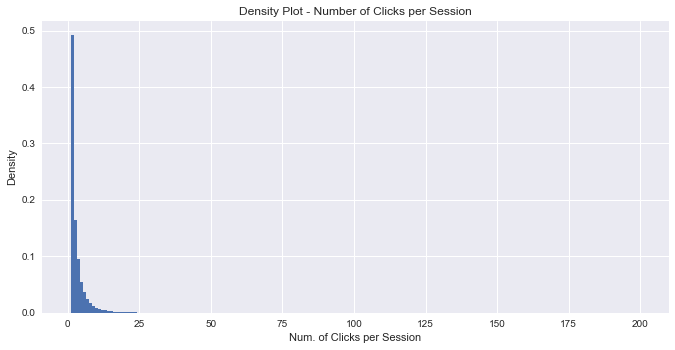

In [116]:
# distribution number of clicks per session
num_clicks_per_sess = clicks_mid[["Session ID","Item ID"]].groupby("Session ID").count()
num_clicks_per_sess.columns = ["num_clicks_session"]
num_clicks_per_sess.hist(bins = 188,density = True,figsize = (10,5))
plt.title('Density Plot - Number of Clicks per Session')
plt.xlabel('Num. of Clicks per Session')
plt.ylabel('Density')

The distribution of the number of clicks per session seems to follow a power-law distribution, with most sessions having less than 10 clicks and a long tail with few sessions having up to 200 clicks.

### Is the average number of clicks per session different between buy and non-buy sessions?

In [117]:
clicks_mid1=clicks_mid[["Session ID","buy_flag","num_clicks_session"]].groupby('Session ID').max()
clicks_mid1.head()

,buy_flag,num_clicks_session
Session ID,,
1,False,4
2,False,6
3,False,3
4,False,2
6,False,2


In [118]:
clicks_mid1[["buy_flag","num_clicks_session"]].groupby("buy_flag").mean()

,num_clicks_session
buy_flag,
False,3.397957
True,6.485605


The average number of clicks of sessions which end with a purchase (6.49) is twice that of sessions without any purchase (3.40).

### 1.2.8 Number of unique items clicked in a session

In [119]:
clicks_mid['unique_items']=clicks_mid[["Session ID","Item ID"]].groupby("Session ID")['Item ID'].transform('nunique')
clicks_mid.head()

<ipython-input-119-e4a7a829012a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks_mid['unique_items']=clicks_mid[["Session ID","Item ID"]].groupby("Session ID")['Item ID'].transform('nunique')


,Session ID,Item ID,Category,hour,day,month,buy_flag,session_length,dwell_time,avg_dwell_time,max_dwell_time,num_clicks_session,unique_items
0,1,214536502,0,10,0,4,False,351.0,180.0,116.666667,180.0,4,4
1,1,214536500,0,10,0,4,False,351.0,37.0,116.666667,180.0,4,4
2,1,214536506,0,10,0,4,False,351.0,133.0,116.666667,180.0,4,4
3,1,214577561,0,10,0,4,False,351.0,NaN,116.666667,180.0,4,4
4,2,214662742,0,13,0,4,False,359.0,41.0,71.400000,118.0,6,5


### Is the number of unique items clicked different between buy and non-buy sessions?

In [120]:
clicks_mid3=clicks_mid[["Session ID","buy_flag","unique_items"]].groupby('Session ID').max()
clicks_mid3.head()

,buy_flag,unique_items
Session ID,,
1,False,4
2,False,5
3,False,3
4,False,2
6,False,2


In [121]:
clicks_mid3.groupby("buy_flag").mean()

,unique_items
buy_flag,
False,2.780412
True,4.541309


Non-buy sessions have a lower number of items clicked than buy sessions. Maybe it is because the former are exploratory sessions in which users just want to look up a couple of products.

### 1.2.9 Merge buy data information

In [122]:
buys.head()

,Session ID,Timestamp,Item ID,Price,Quantity
0,420374,2014-04-06 18:44:58.314000+00:00,214537888,12462,1
1,420374,2014-04-06 18:44:58.325000+00:00,214537850,10471,1
2,281626,2014-04-06 09:40:13.032000+00:00,214535653,1883,1
3,420368,2014-04-04 06:13:28.848000+00:00,214530572,6073,1
4,420368,2014-04-04 06:13:28.858000+00:00,214835025,2617,1


In [123]:
buys1 = buys.groupby(['Session ID','Item ID'], as_index=False)['Price'].count()
buys2 = buys1[buys1['Price']>1]
buys2.head(20)

,Session ID,Item ID,Price
0,11,214821371,2
4,33,214706441,2
5,33,214820225,2
6,33,214834865,2
7,46,214716932,2
18,182,214535621,2
29,319,214600625,2
32,367,214821290,2
33,382,214534852,2
35,408,214594680,2


In [124]:
buys[(buys['Session ID'] == 12 )]

,Session ID,Timestamp,Item ID,Price,Quantity
12,12,2014-04-02 10:42:17.227000+00:00,214717867,1778,4


There are instances where similar item was bought multiple times in similar session but due to no information available we are summing the information

### 1.2.10 Purchase ratio by hour 

In [125]:
clicks_merge_hour=clicks_mid.groupby('Session ID').agg({'num_clicks_session':max,'buy_flag':max, 'hour':max })
clicks_merge_hour.head()

,num_clicks_session,buy_flag,hour
Session ID,,,
1,4,False,10
2,6,False,14
3,3,False,13
4,2,False,12
6,2,False,17


In [126]:
p_ratio_by_hour = clicks_merge_hour[['hour','num_clicks_session','buy_flag']].groupby('hour').agg({'num_clicks_session':sum,'buy_flag':sum })
p_ratio_by_hour['purchase_ratio']=p_ratio_by_hour['buy_flag']/p_ratio_by_hour['num_clicks_session']
p_ratio_by_hour.head()

,num_clicks_session,buy_flag,purchase_ratio
hour,,,
0,115522,669.0,0.005791
1,104908,669.0,0.006377
2,103957,666.0,0.006406
3,142524,1167.0,0.008188
4,365501,3709.0,0.010148


Text(0, 0.5, 'Num. Purchases / Num. Clicks')

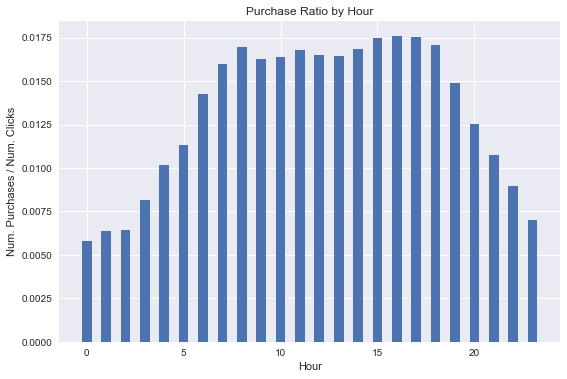

In [128]:
plt.bar(p_ratio_by_hour.index, p_ratio_by_hour['purchase_ratio'], width=0.5)
plt.title('Purchase Ratio by Hour')
plt.xlabel('Hour')
plt.ylabel('Num. Purchases / Num. Clicks')

The ratio is higher between 6 am and 7 pm.

### 1.2.11 Purchase ratio by day of the week

In [129]:
clicks_merge_day=clicks_mid.groupby('Session ID').agg({'num_clicks_session':max,'buy_flag':max, 'day':max })
clicks_merge_day.head()

,num_clicks_session,buy_flag,day
Session ID,,,
1,4,False,0
2,6,False,0
3,3,False,2
4,2,False,0
6,2,False,6


In [130]:
p_ratio_by_day = clicks_merge_day[['day','num_clicks_session','buy_flag']].groupby('day').agg({'num_clicks_session':sum,'buy_flag':sum })
p_ratio_by_day['purchase_ratio']=p_ratio_by_day['buy_flag']/p_ratio_by_day['num_clicks_session']
p_ratio_by_day.head(7)

,num_clicks_session,buy_flag,purchase_ratio
day,,,
0,6569452,98983.0,0.015067
1,2233064,20889.0,0.009354
2,4795384,68337.0,0.014251
3,4513700,68629.0,0.015205
4,3614249,58130.0,0.016084
5,3906875,72193.0,0.018478
6,7371220,122535.0,0.016623


Text(0, 0.5, 'Num. Purchases / Num. Clicks')

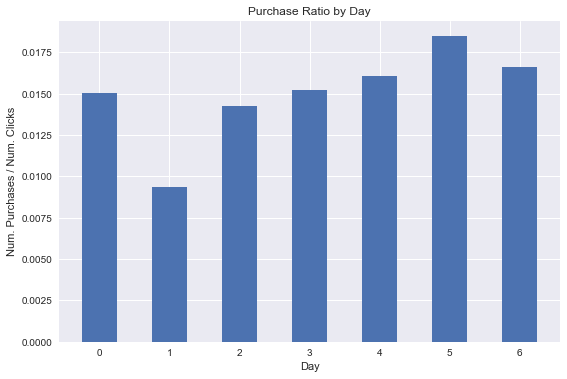

In [131]:
plt.bar(p_ratio_by_day.index, p_ratio_by_day['purchase_ratio'], width=0.5)
plt.title('Purchase Ratio by Day')
plt.xlabel('Day')
plt.ylabel('Num. Purchases / Num. Clicks')

Tuesday has the lowest ratio, while Saturday and Sunday have the highest ones, which seems reasonable since usually people have more time for shopping in the weekend. 

### 1.2.12 Purchase ratio by month

In [132]:
clicks_merge_month=clicks_mid.groupby('Session ID').agg({'num_clicks_session':max,'buy_flag':max, 'month':max })
clicks_merge_month.head()

,num_clicks_session,buy_flag,month
Session ID,,,
1,4,False,4
2,6,False,4
3,3,False,4
4,2,False,4
6,2,False,4


In [133]:
p_ratio_by_month = clicks_merge_month[['month','num_clicks_session','buy_flag']].groupby('month').agg({'num_clicks_session':sum,'buy_flag':sum })
p_ratio_by_month['purchase_ratio']=p_ratio_by_month['buy_flag']/p_ratio_by_month['num_clicks_session']
p_ratio_by_month.head(6)

,num_clicks_session,buy_flag,purchase_ratio
month,,,
4,5973206,91587.0,0.015333
5,5544319,88005.0,0.015873
6,5127167,76493.0,0.014919
7,4434003,67347.0,0.015189
8,6646405,105153.0,0.015821
9,5278844,81111.0,0.015365


Text(0, 0.5, 'Num. Purchases / Num. Clicks')

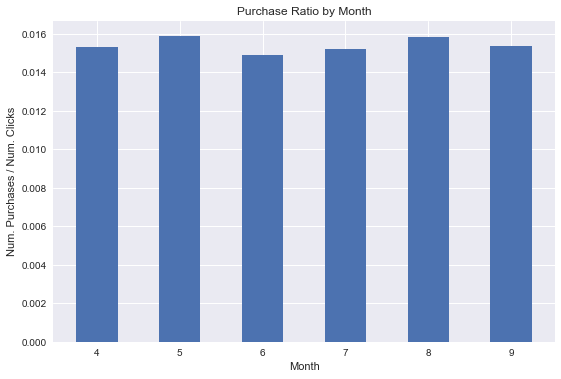

In [134]:
plt.bar(p_ratio_by_month.index, p_ratio_by_month['purchase_ratio'], width=0.5)
plt.title('Purchase Ratio by Month')
plt.xlabel('Month')
plt.ylabel('Num. Purchases / Num. Clicks')

### 1.2.13 Purchase ratio by session’s length

In [135]:
clicks_merge_length=clicks_mid.groupby('Session ID').agg({'num_clicks_session':max,'buy_flag':max, 'session_length':max })
clicks_merge_length.head()

,num_clicks_session,buy_flag,session_length
Session ID,,,
1,4,False,351.0
2,6,False,359.0
3,3,False,745.0
4,2,False,1034.0
6,2,False,246.0


In [136]:
#converting length from seconds to minutes for better interpretability
clicks_merge_length['session_length']=clicks_merge_length['session_length']/60

# create bins for length in minutes 
bins = [0, 2, 5, 8, 11, 14, 17, 20,(clicks_merge_length.session_length.max()+1)]
clicks_merge_length['length_bins'] = pd.cut(clicks_merge_length['session_length'], bins, include_lowest=True)
clicks_merge_length.head()

,num_clicks_session,buy_flag,session_length,length_bins
Session ID,,,,
1,4,False,5.850000,"(5.0, 8.0]"
2,6,False,5.983333,"(5.0, 8.0]"
3,3,False,12.416667,"(11.0, 14.0]"
4,2,False,17.233333,"(17.0, 20.0]"
6,2,False,4.100000,"(2.0, 5.0]"


In [137]:
p_ratio_by_length = clicks_merge_length[['length_bins','num_clicks_session','buy_flag']].groupby('length_bins').agg({'num_clicks_session':sum,'buy_flag':sum })
p_ratio_by_length['purchase_ratio']=p_ratio_by_length['buy_flag']/p_ratio_by_length['num_clicks_session']
p_ratio_by_length.reset_index(inplace=True)
p_ratio_by_length.head(10)

,length_bins,num_clicks_session,buy_flag,purchase_ratio
0,"(-0.001, 2.0]",8984433,102663.0,0.011427
1,"(2.0, 5.0]",6688493,89026.0,0.013310
2,"(5.0, 8.0]",3937404,65469.0,0.016627
3,"(8.0, 11.0]",2603307,48698.0,0.018706
4,"(11.0, 14.0]",1858101,36889.0,0.019853
5,"(14.0, 17.0]",1396556,28473.0,0.020388
6,"(17.0, 20.0]",1076923,22321.0,0.020727
7,"(20.0, 4099.95]",6458727,116157.0,0.017985


Text(0, 0.5, 'Num. Purchases / Num. Clicks')

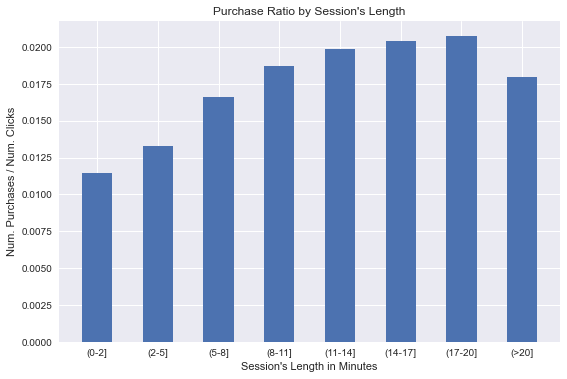

In [140]:
plt.bar(p_ratio_by_length.index, p_ratio_by_length['purchase_ratio'], width=0.5)
xtick=['(0-2]','(2-5]','(5-8]','(8-11]','(11-14]','(14-17]','(17-20]','(>20]']
plt.xticks(p_ratio_by_length.index,xtick)
plt.title("Purchase Ratio by Session's Length")
plt.xlabel("Session's Length in Minutes")
plt.ylabel('Num. Purchases / Num. Clicks')

### Splitting train and test

In [49]:
buys['month'] =buys.Timestamp.dt.month
buys.month.unique()

array([4, 5, 6, 7, 8, 9], dtype=int64)

In [50]:
clicks_mid.month.unique()

array([4, 5, 6, 7, 8, 9], dtype=int64)

In [51]:
buys_train = buys[buys['month']!=9]
buys_test = buys[buys['month']==9]
print(f"Number of records buy train dataset: {buys_train.shape}") 
print(f"Number of records buy test dataset: {buys_test.shape}") 
print(f"Number of unique sessions buys train dataset: {buys_train['Session ID'].nunique()}") 
print(f"Number of unique sessions buys test dataset: {buys_test['Session ID'].nunique()}")

Number of records buy train dataset: (947629, 6)
Number of records buy test dataset: (203124, 6)
Number of unique sessions buys train dataset: 428584
Number of unique sessions buys test dataset: 81112


### Item Price Calculation using weighted average price methodology
To reduce the bias, item level calculations are done separately for train and test dataset

In [52]:
buys_train['Amount'] = buys_train['Quantity']*buys_train['Price']
item_amount = buys_train.groupby(['Item ID'],as_index=False)['Amount'].sum()
item_quanity = buys_train.groupby(['Item ID'],as_index=False)['Quantity'].sum()
item_price1=item_amount.merge(item_quanity,on='Item ID', how='left')
item_price1['Price']=item_price1['Amount']/item_price1['Quantity']
item_price1.head()

<ipython-input-52-df1addbc68ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buys_train['Amount'] = buys_train['Quantity']*buys_train['Price']


,Item ID,Amount,Quantity,Price
0,214507331,320382,102,3141.00000
1,214507365,26936,52,518.00000
2,214507385,56064,192,292.00000
3,214507387,30557,109,280.33945
4,214507408,13680,57,240.00000


In [53]:
clicks_train = clicks_mid[(clicks_mid['month']!=9)]
clicks_test = clicks_mid[(clicks_mid['month']==9)]
print(f"Number of records clicks train dataset: {clicks_train.shape}") 
print(f"Number of records clicks test dataset: {clicks_test.shape}") 
print(f"Number of unique sessions clicks train dataset: {clicks_train['Session ID'].nunique()}") 
print(f"Number of unique sessions clicks test dataset: {clicks_test['Session ID'].nunique()}")

Number of records clicks train dataset: (27725422, 13)
Number of records clicks test dataset: (5278522, 13)
Number of unique sessions clicks train dataset: 7710325
Number of unique sessions clicks test dataset: 1539462


In [54]:
buys_item_train = buys_train.groupby('Item ID', as_index=False)['Session ID'].nunique()
#clicks_train=clicks_merge[clicks_merge['month']!=9]
clicks_item_train = clicks_train.groupby('Item ID', as_index=False)['Session ID'].nunique()
clicks_item_test = clicks_test.groupby('Item ID', as_index=False)['Session ID'].nunique()

In [55]:
item_price1= item_price1.rename(columns= {'Price':'Avg_item_price'})
buys_item_train=buys_item_train.rename(columns={'Session ID':'Buy_sessions'})
clicks_item_train=clicks_item_train.rename(columns={'Session ID':'Click_sessions'})
clicks_item_train = clicks_item_train.merge(buys_item_train, on ='Item ID', how='left')
clicks_item_train = clicks_item_train.merge(item_price1, on ='Item ID', how='left')

In [56]:
clicks_item_train = clicks_item_train.fillna(0)
clicks_item_train['Popularity']=clicks_item_train['Buy_sessions']/clicks_item_train['Click_sessions']

clicks_item_train.head()

,Item ID,Click_sessions,Buy_sessions,Amount,Quantity,Avg_item_price,Popularity
0,214507224,7,0.0,0.0,0.0,0.0,0.0
1,214507226,6,0.0,0.0,0.0,0.0,0.0
2,214507228,1,0.0,0.0,0.0,0.0,0.0
3,214507239,3,0.0,0.0,0.0,0.0,0.0
4,214507256,1,0.0,0.0,0.0,0.0,0.0


In [57]:
clicks_item_train['Popularity_Rank'] = clicks_item_train['Popularity'].rank(ascending=False, method='dense')
clicks_item_train.sort_values(by='Popularity_Rank')

,Item ID,Click_sessions,Buy_sessions,Amount,Quantity,Avg_item_price,Popularity,Popularity_Rank
37128,214809667,1,1.0,0.0,0.0,0.0,1.0,1.0
49007,214855650,1,1.0,93.0,1.0,93.0,1.0,1.0
35151,214788622,1,1.0,0.0,0.0,0.0,1.0,1.0
36453,214802507,1,1.0,0.0,0.0,0.0,1.0,1.0
39714,214826025,1,1.0,2712.0,1.0,2712.0,1.0,1.0
...,...,...,...,...,...,...,...,...
24226,214696723,2,0.0,0.0,0.0,0.0,0.0,7953.0
24230,214696732,4,0.0,0.0,0.0,0.0,0.0,7953.0
24231,214696734,1,0.0,0.0,0.0,0.0,0.0,7953.0
24217,214696670,10,0.0,0.0,0.0,0.0,0.0,7953.0


### Popularity Score in terms of number of buys vs number of clicks

In [58]:
hist = clicks_item_train[(clicks_item_train["Popularity"]!= 0)]
hist["Popularity"].dropna().quantile([0.0, .1, 0.2,0.3,0.35,0.4,0.5,0.6,.90, .95])

0.00    0.000295
0.10    0.006189
0.20    0.010653
0.30    0.015682
0.35    0.018519
0.40    0.021739
0.50    0.029412
0.60    0.038835
0.90    0.125000
0.95    0.200000
Name: Popularity, dtype: float64

In [59]:
clicks_item_train.shape

(50046, 8)

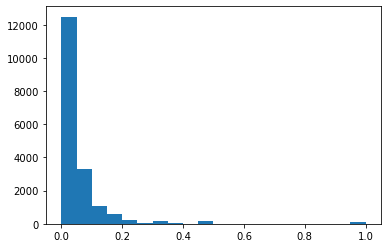

In [60]:
plt.hist(hist["Popularity"],bins = 20)
plt.show()

In [61]:
clicks_item_train['Popularity_flag']= clicks_item_train['Popularity'].apply(lambda x: 1 if x > 0.009 else 0)
clicks_item_train.head()

,Item ID,Click_sessions,Buy_sessions,Amount,Quantity,Avg_item_price,Popularity,Popularity_Rank,Popularity_flag
0,214507224,7,0.0,0.0,0.0,0.0,0.0,7953.0,0
1,214507226,6,0.0,0.0,0.0,0.0,0.0,7953.0,0
2,214507228,1,0.0,0.0,0.0,0.0,0.0,7953.0,0
3,214507239,3,0.0,0.0,0.0,0.0,0.0,7953.0,0
4,214507256,1,0.0,0.0,0.0,0.0,0.0,7953.0,0


In [81]:
#clicks_train = clicks_train.merge(clicks_item_train,on=['Item ID'], how='left')
clicks_train.head()

NameError: name 'clicks_train' is not defined

In [63]:
clicks_test = clicks_test.merge(clicks_item_train[['Item ID','Popularity_flag']],on=['Item ID'], how='left')
clicks_test.head()

,Session ID,Item ID,Category,hour,day,month,buy_flag,session_length,dwell_time,avg_dwell_time,max_dwell_time,num_clicks_session,unique_items,Popularity_flag
0,9293604,214839911,S,18,0,9,False,0.0,NaN,NaN,NaN,1,1,1.0
1,9293603,214701787,S,14,0,9,False,114.0,73.0,56.5,73.0,3,2,1.0
2,9293603,214853657,1,14,0,9,False,114.0,40.0,56.5,73.0,3,2,1.0
3,9293603,214701787,S,14,0,9,False,114.0,NaN,56.5,73.0,3,2,1.0
4,9293613,214834871,S,15,0,9,False,9.0,9.0,9.0,9.0,2,2,1.0


### calculate max clicks per item within a session

In [64]:
clicks_merge=clicks_train.append(clicks_test)

In [83]:
###to clean the datasets
import gc
#del[clicks_train,clicks_test, clicks_mid]
gc.collect()
clicks_train=pd.DataFrame()
clicks_test=pd.DataFrame()
clicks_mid=pd.DataFrame()

In [84]:
clicks_merge.head()

,Session ID,Item ID,Category,hour,day,month,buy_flag,session_length,dwell_time,avg_dwell_time,...,Click_sessions,Buy_sessions,Amount,Quantity,Avg_item_price,Popularity,Popularity_Rank,Popularity_flag,max_click_per_item,Category_flag
0,1,214536502,0,10,0,4,False,351.0,180.0,116.666667,...,1440.0,23.0,73280.0,20.0,3664.0,0.015972,5445.0,1.0,1,No Category
1,1,214536500,0,10,0,4,False,351.0,37.0,116.666667,...,428.0,3.0,0.0,0.0,0.0,0.007009,6786.0,0.0,1,No Category
2,1,214536506,0,10,0,4,False,351.0,133.0,116.666667,...,54.0,2.0,5022.0,3.0,1674.0,0.037037,3307.0,1.0,1,No Category
3,1,214577561,0,10,0,4,False,351.0,NaN,116.666667,...,106.0,0.0,0.0,0.0,0.0,0.000000,7953.0,0.0,1,No Category
4,2,214662742,0,13,0,4,False,359.0,41.0,71.400000,...,2124.0,13.0,28578.0,11.0,2598.0,0.006121,6931.0,0.0,2,No Category


In [65]:
#clicks_train.to_csv('clicks_train.csv')
#clicks_test.to_csv('clicks_test.csv')

In [66]:
# number of unique sessions
print(f"Number of unique sessions clicks dataset: {clicks['Session ID'].nunique()}") 
print(f"Number of unique sessions buys dataset: {clicks_merge['Session ID'].nunique()}") 
# proportion of sessions resulting in purchase
print(f"The proportion of session resulting in a purchase is: {round(buys['Session ID'].nunique()/clicks_merge['Session ID'].nunique(),3)}") 

Number of unique sessions clicks dataset: 9249729
Number of unique sessions buys dataset: 9249729
The proportion of session resulting in a purchase is: 0.055


In [67]:
clicks_item_max = clicks_merge.groupby(['Session ID','Item ID'], as_index=False)['hour'].count()

In [68]:
clicks_item_max1 = clicks_item_max.groupby(['Session ID'], as_index=False)['hour'].max()

In [69]:
clicks_item_max1 = clicks_item_max1.rename(columns={'hour':'max_click_per_item'})
clicks_item_max1.head()

,Session ID,max_click_per_item
0,1,1
1,2,2
2,3,1
3,4,1
4,6,1


In [70]:
clicks_merge = clicks_merge.merge(clicks_item_max1,on='Session ID', how='left')
clicks_merge.shape

(33003944, 22)

In [71]:
clicks_merge.head()

,Session ID,Item ID,Category,hour,day,month,buy_flag,session_length,dwell_time,avg_dwell_time,...,unique_items,Click_sessions,Buy_sessions,Amount,Quantity,Avg_item_price,Popularity,Popularity_Rank,Popularity_flag,max_click_per_item
0,1,214536502,0,10,0,4,False,351.0,180.0,116.666667,...,4,1440.0,23.0,73280.0,20.0,3664.0,0.015972,5445.0,1.0,1
1,1,214536500,0,10,0,4,False,351.0,37.0,116.666667,...,4,428.0,3.0,0.0,0.0,0.0,0.007009,6786.0,0.0,1
2,1,214536506,0,10,0,4,False,351.0,133.0,116.666667,...,4,54.0,2.0,5022.0,3.0,1674.0,0.037037,3307.0,1.0,1
3,1,214577561,0,10,0,4,False,351.0,NaN,116.666667,...,4,106.0,0.0,0.0,0.0,0.0,0.000000,7953.0,0.0,1
4,2,214662742,0,13,0,4,False,359.0,41.0,71.400000,...,5,2124.0,13.0,28578.0,11.0,2598.0,0.006121,6931.0,0.0,2


### Item category flag

In [72]:
clicks_merge['Category_flag']= 'Regular'
clicks_merge.loc[clicks_merge['Category'] == 'S', 'Category_flag'] = 'Offer'  
clicks_merge.loc[clicks_merge['Category'] == '0', 'Category_flag'] = 'No Category'  
clicks_merge.loc[clicks_merge['Category'].str.len()>2, 'Category_flag'] = 'Sports'  

In [73]:
session_category = clicks_merge.groupby(['Session ID', 'Category_flag'])['Item ID'].nunique()
session_category_st = session_category.unstack()
session_category_st.head()

Category_flag,No Category,Offer,Regular,Sports
Session ID,,,,
1,4.0,NaN,NaN,NaN
2,5.0,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN
6,2.0,NaN,NaN,NaN


### Popularity count within a session

In [74]:
session_popularity = clicks_merge.groupby(['Session ID', 'Popularity_flag'])['Item ID'].nunique()
session_popularity_st = session_popularity.unstack()
session_popularity_st.head()

Popularity_flag,0.0,1.0
Session ID,,
1,2.0,2.0
2,4.0,1.0
3,NaN,3.0
4,1.0,1.0
6,NaN,2.0


### Average Price per item within session

In [85]:
session_item_price = clicks_merge[clicks_merge['Avg_item_price']>0].groupby(['Session ID'], as_index=False)['Avg_item_price'].mean()
#session_item_price_st = session_item_price.unstack()
session_item_price.head()

,Session ID,Avg_item_price
0,1,2669.000000
1,2,2382.333333
2,3,4701.595023
3,4,20315.500000
4,6,6336.696891


In [86]:
session_item_pop = clicks_merge[clicks_merge['Popularity']>0].groupby(['Session ID'], as_index=False)['Popularity'].mean()
#session_item_price_st = session_item_price.unstack()
session_item_pop.head()

,Session ID,Popularity
0,1,0.020006
1,2,0.006365
2,3,0.026714
3,4,0.006692
4,6,0.025385


### Final Session Level data preparation

In [87]:
clicks_merge.head()

,Session ID,Item ID,Category,hour,day,month,buy_flag,session_length,dwell_time,avg_dwell_time,...,Click_sessions,Buy_sessions,Amount,Quantity,Avg_item_price,Popularity,Popularity_Rank,Popularity_flag,max_click_per_item,Category_flag
0,1,214536502,0,10,0,4,False,351.0,180.0,116.666667,...,1440.0,23.0,73280.0,20.0,3664.0,0.015972,5445.0,1.0,1,No Category
1,1,214536500,0,10,0,4,False,351.0,37.0,116.666667,...,428.0,3.0,0.0,0.0,0.0,0.007009,6786.0,0.0,1,No Category
2,1,214536506,0,10,0,4,False,351.0,133.0,116.666667,...,54.0,2.0,5022.0,3.0,1674.0,0.037037,3307.0,1.0,1,No Category
3,1,214577561,0,10,0,4,False,351.0,NaN,116.666667,...,106.0,0.0,0.0,0.0,0.0,0.000000,7953.0,0.0,1,No Category
4,2,214662742,0,13,0,4,False,359.0,41.0,71.400000,...,2124.0,13.0,28578.0,11.0,2598.0,0.006121,6931.0,0.0,2,No Category


In [88]:
clicks_merge.columns

Index(['Session ID', 'Item ID', 'Category', 'hour', 'day', 'month', 'buy_flag',
       'session_length', 'dwell_time', 'avg_dwell_time', 'max_dwell_time',
       'num_clicks_session', 'unique_items', 'Click_sessions', 'Buy_sessions',
       'Amount', 'Quantity', 'Avg_item_price', 'Popularity', 'Popularity_Rank',
       'Popularity_flag', 'max_click_per_item', 'Category_flag'],
      dtype='object')

In [89]:
final_session= clicks_merge[['Session ID','hour','day','month','num_clicks_session','buy_flag','session_length','avg_dwell_time','max_dwell_time',
                          'unique_items','max_click_per_item']]
final_session = final_session.drop_duplicates()
final_session.head()

,Session ID,hour,day,month,num_clicks_session,buy_flag,session_length,avg_dwell_time,max_dwell_time,unique_items,max_click_per_item
0,1,10,0,4,4,False,351.0,116.666667,180.0,4,1
4,2,13,0,4,6,False,359.0,71.400000,118.0,5,2
8,2,14,0,4,6,False,359.0,71.400000,118.0,5,2
10,3,13,2,4,3,False,745.0,372.000000,495.0,3,1
13,4,12,0,4,2,False,1034.0,1034.000000,1034.0,2,1


In [90]:
final_session['max_hour']=final_session.groupby(['Session ID'])['hour'].transform(max)
final_session['max_day']=final_session.groupby(['Session ID'])['day'].transform(max)
final_session['max_month']=final_session.groupby(['Session ID'])['month'].transform(max)
final_session.shape

(10229290, 14)

There are sessions with different times and days mostly as the night hour so taking the max of the time variables

In [91]:
final_session = final_session.drop(columns={'hour','day','month'})
final_session = final_session.drop_duplicates()
final_session.head()

,Session ID,num_clicks_session,buy_flag,session_length,avg_dwell_time,max_dwell_time,unique_items,max_click_per_item,max_hour,max_day,max_month
0,1,4,False,351.0,116.666667,180.0,4,1,10,0,4
4,2,6,False,359.0,71.400000,118.0,5,2,14,0,4
10,3,3,False,745.0,372.000000,495.0,3,1,13,2,4
13,4,2,False,1034.0,1034.000000,1034.0,2,1,12,0,4
15,6,2,False,246.0,246.000000,246.0,2,1,17,6,4


In [92]:
final_session.shape

(9249729, 11)

In [93]:
final_session = final_session.merge(session_category_st, how='left',on='Session ID')
final_session = final_session.merge(session_popularity_st, how='left',on='Session ID')
final_session = final_session.merge(session_item_price, how='left',on='Session ID')
final_session = final_session.merge(session_item_pop, how='left',on='Session ID')
#final_session.head()

In [94]:
final_session = final_session.fillna(0)
final_session.head()

,Session ID,num_clicks_session,buy_flag,session_length,avg_dwell_time,max_dwell_time,unique_items,max_click_per_item,max_hour,max_day,max_month,No Category,Offer,Regular,Sports,0.0,1.0,Avg_item_price,Popularity
0,1,4,False,351.0,116.666667,180.0,4,1,10,0,4,4.0,0.0,0.0,0.0,2.0,2.0,2669.000000,0.020006
1,2,6,False,359.0,71.400000,118.0,5,2,14,0,4,5.0,0.0,0.0,0.0,4.0,1.0,2382.333333,0.006365
2,3,3,False,745.0,372.000000,495.0,3,1,13,2,4,3.0,0.0,0.0,0.0,0.0,3.0,4701.595023,0.026714
3,4,2,False,1034.0,1034.000000,1034.0,2,1,12,0,4,2.0,0.0,0.0,0.0,1.0,1.0,20315.500000,0.006692
4,6,2,False,246.0,246.000000,246.0,2,1,17,6,4,2.0,0.0,0.0,0.0,0.0,2.0,6336.696891,0.025385


In [95]:
final_session['perc_prod_offer']=final_session['Offer']/final_session['unique_items']
final_session['perc_prod_no_cat']=final_session['No Category']/final_session['unique_items']
final_session['perc_prod_pop']=final_session[0]/final_session['unique_items']
#final_session.head()

In [96]:
final_session.columns

Index([        'Session ID', 'num_clicks_session',           'buy_flag',
           'session_length',     'avg_dwell_time',     'max_dwell_time',
             'unique_items', 'max_click_per_item',           'max_hour',
                  'max_day',          'max_month',        'No Category',
                    'Offer',            'Regular',             'Sports',
                        0.0,                  1.0,     'Avg_item_price',
               'Popularity',    'perc_prod_offer',   'perc_prod_no_cat',
            'perc_prod_pop'],
      dtype='object')

In [98]:
#final_session = final_session.rename(columns={'avg_dwell_time':'Avg_time_bet_clicks','max_dwell_time':'Max_time_bet_clicks'})
final_session_level=final_session[['Session ID',  'num_clicks_session', 'buy_flag',
                    'session_length', 'Avg_time_bet_clicks', 'Max_time_bet_clicks',
                 'unique_items',  'max_click_per_item',            'max_hour',
                   'max_day',           'max_month',         'Avg_item_price',
                'Popularity',     'perc_prod_offer',    'perc_prod_no_cat',
             'perc_prod_pop']]
final_session_level.shape

(9249729, 16)

In [99]:
final_session_level.head()

,Session ID,num_clicks_session,buy_flag,session_length,Avg_time_bet_clicks,Max_time_bet_clicks,unique_items,max_click_per_item,max_hour,max_day,max_month,Avg_item_price,Popularity,perc_prod_offer,perc_prod_no_cat,perc_prod_pop
0,1,4,False,351.0,116.666667,180.0,4,1,10,0,4,2669.000000,0.020006,0.0,1.0,0.5
1,2,6,False,359.0,71.400000,118.0,5,2,14,0,4,2382.333333,0.006365,0.0,1.0,0.8
2,3,3,False,745.0,372.000000,495.0,3,1,13,2,4,4701.595023,0.026714,0.0,1.0,0.0
3,4,2,False,1034.0,1034.000000,1034.0,2,1,12,0,4,20315.500000,0.006692,0.0,1.0,0.5
4,6,2,False,246.0,246.000000,246.0,2,1,17,6,4,6336.696891,0.025385,0.0,1.0,0.0


In [100]:
final_session_level_train = final_session_level[(final_session_level['max_month']!=9)]
final_session_level_test = final_session_level[(final_session_level['max_month']==9)]
print(f"Number of records clicks train dataset: {final_session_level_train.shape}") 
print(f"Number of records clicks test dataset: {final_session_level_test.shape}") 
print(f"Number of unique sessions clicks train dataset: {final_session_level_train['Session ID'].nunique()}") 
print(f"Number of unique sessions clicks test dataset: {final_session_level_test['Session ID'].nunique()}")

Number of records clicks train dataset: (7710267, 16)
Number of records clicks test dataset: (1539462, 16)
Number of unique sessions clicks train dataset: 7710267
Number of unique sessions clicks test dataset: 1539462


In [101]:
final_session_level_train.to_csv('final_session_level_train.csv')
final_session_level_test.to_csv('final_session_level_test.csv')

**In our final dataset, as we have to find whether a session is a buying session or non-buying session, we have following features**:
- num_clicks_session: total clicks in a given session	
- buy_flag: whether a session ended in a purchase
- session_length: Time spent by a user in a session in second
- Avg_time_bet_clicks: average time between any two consecutive clicks in a given session
- Max_time_bet_clicks: maximum time between any two consecutive clicks in a given session
- unique_items: number of unique items clicked in a session
- max_click_per_item: maximum clicks on an item in asession
- max_hour: hour of the day when session was open
- max_day: day of the week when session was open
- max_month: month of the year when session was open
- Avg_item_price: average price of the items in a session
- Popularity: average popularity of items in a session
- perc_prod_offer: percentage of items clicked in a session that were on an offer
- perc_prod_no_cat: percentage of items clicked in a session with no category
- perc_prod_pop: percentage of products that are popular in a session which is calulated based on purchase ratio

### For Session Item Level feature preparation, please refer to the other notebook - "HW3 - DMA Item Features" - Section 1.3